In [3]:
#import packages
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [4]:
#read data from data ingestor script
df = pd.read_csv('transactions.csv')

df.head()

,Unnamed: 0,country,customer_id,invoice,year,month,day,stream_id,times_viewed,price
0,0,United Kingdom,15581.0,493463,2018,1,1,20895,1,2.95
1,1,United Kingdom,15581.0,493463,2018,1,1,20866,1,1.25
2,2,United Kingdom,15581.0,493463,2018,1,1,85198,12,0.85
3,3,United Kingdom,15581.0,493463,2018,1,1,20897,1,2.95
4,4,United Kingdom,15581.0,493463,2018,1,1,20898,1,2.95


In [4]:
#initial dtypes
df.dtypes

Unnamed: 0        int64
country          object
customer_id     float64
invoice          object
year              int64
month             int64
day               int64
stream_id        object
times_viewed      int64
price           float64
dtype: object

In [85]:
#make country, stream id, invoice, customer_id categorical
df[['country', 'stream_id', 'invoice', 'customer_id']] = df[['country', 'stream_id', 'invoice', 'customer_id']].astype('category')

In [140]:
df.dtypes

country               category
customer_id           category
invoice               category
year                     int64
month                    int64
day                      int64
stream_id             category
times_viewed             int64
price                  float64
date            datetime64[ns]
year-month              object
dtype: object

In [6]:
#drop 'unnamed' column
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [7]:
#create date column
#day, month and years to be concatenated into one value to be stored in this column
df['date'] = np.NaN
df['date'] = df['year'].astype(str) + df['month'].astype(str).str.zfill(2) + df['day'].astype(str).str.zfill(2)
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

In [8]:
#create year-month column
#to allow aggregation of price per month
df['year-month'] = np.NaN
df['year-month'] = df['year'].astype(str) + df['month'].astype(str).str.zfill(2)
df['year-month'] = pd.to_datetime(df['year-month'], format='%Y%m').dt.strftime('%Y-%m')

In [116]:
#view changes to compare pre-manipulations to post-manipulations
df.head()

,country,customer_id,invoice,year,month,day,stream_id,times_viewed,price,date,year-month
0,United Kingdom,15581.0,493463,2018,1,1,20895,1,2.95,2018-01-01,2018-01
1,United Kingdom,15581.0,493463,2018,1,1,20866,1,1.25,2018-01-01,2018-01
2,United Kingdom,15581.0,493463,2018,1,1,85198,12,0.85,2018-01-01,2018-01
3,United Kingdom,15581.0,493463,2018,1,1,20897,1,2.95,2018-01-01,2018-01
4,United Kingdom,15581.0,493463,2018,1,1,20898,1,2.95,2018-01-01,2018-01


In [146]:
#check data shape
df.shape
#815k rows of individual transactions

(815011, 11)

In [143]:
#check for missing data
df.isna().sum()
#189k of missing customer ids
#~25%/1 in 4 of customer ids are missing

country              0
customer_id     189762
invoice              0
year                 0
month                0
day                  0
stream_id            0
times_viewed         0
price                0
date                 0
year-month           0
dtype: int64

In [144]:
#descriptive stats of numerical variables, excluding day/month/year
df[['times_viewed','price']].describe()

,times_viewed,price
count,815011.000000,815011.000000
mean,5.231106,4.802631
std,5.109982,135.058707
min,0.000000,-53594.360000
25%,1.000000,1.250000
50%,3.000000,2.100000
75%,8.000000,4.210000
max,24.000000,38970.000000


In [9]:
#group by date, year, month, aggregation = sum
dfdate = df.groupby(by=['date','country']).sum()
dfyear = df.groupby(by=['year']).sum()
dfmonth = df.groupby(by=['year-month']).sum()

In [10]:
#save csv file with index as the date
dfdate.to_csv('transactions_date_index.csv')

Text(0, 0.5, 'Total revenue in millions')

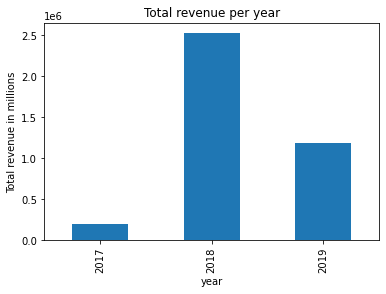

In [11]:
#visualise revenue per year
dfyear['price'].plot(kind='bar', title='Total revenue per year').set_ylabel('Total revenue in millions')

Text(0.5, 0, 'Total revenue')

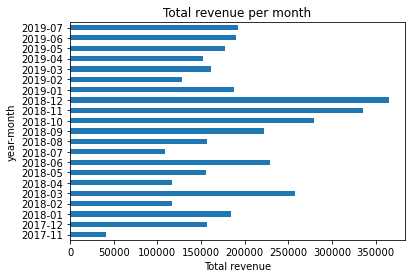

In [12]:
#visualise revenue per month
dfmonth['price'].plot(kind='barh', title='Total revenue per month').set_xlabel('Total revenue')

In [13]:
#group by country and find top 10 highest revenue countries
dfcountry = df.groupby(by='country').sum()
dfcountry['price'] = dfcountry['price'].round(2)

#top 10 countries with the highest revenue:
top10 = dfcountry.sort_values(by='price', ascending=False)[:10]

In [14]:
#list full revenue totals
top10['price']

country
United Kingdom    3521513.51
EIRE               107069.21
Germany             49271.82
France              40565.14
Norway              38494.75
Spain               16040.99
Hong Kong           14452.57
Portugal            13528.67
Singapore           13175.92
Netherlands         12322.80
Name: price, dtype: float64

In [15]:
#save top 10 countries into a list
top10revenuecountries = top10.index.to_list()
top10revenuecountries

['United Kingdom',
 'EIRE',
 'Germany',
 'France',
 'Norway',
 'Spain',
 'Hong Kong',
 'Portugal',
 'Singapore',
 'Netherlands']

Text(0.5, 0, 'Total revenue')

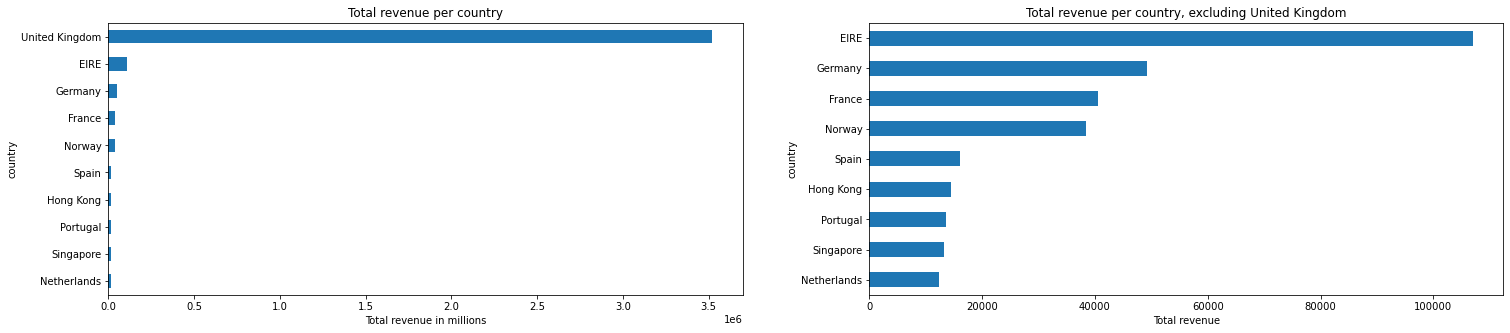

In [108]:
#plot revenue by country
fig, axs = plt.subplots(1,2, figsize=(25,5))

top10['price'].sort_values(ascending=True).plot(kind='barh', ax=axs[0])
axs[0].set_title('Total revenue per country')
axs[0].xaxis.set_label_text('Total revenue in millions')

#excluding the UK
top10['price'][1:10].sort_values(ascending=True).plot(kind='barh', ax=axs[1])
axs[1].set_title('Total revenue per country, excluding United Kingdom')
axs[1].xaxis.set_label_text('Total revenue')

In [17]:
#get indexes for non top 10 countries and remove rows to leave data for top 10 countries only
indexnames = df[~df['country'].isin(top10revenuecountries)].index
dftop10 = df.drop(indexnames)
dftop10['country'].value_counts()

United Kingdom          751228
EIRE                     13577
Germany                  13336
France                    9899
Netherlands               4024
Spain                     2606
Portugal                  1815
Norway                     796
Singapore                  310
Hong Kong                  276
Finland                      0
European Community           0
Denmark                      0
Czech Republic               0
West Indies                  0
Cyprus                       0
Channel Islands              0
Canada                       0
Brazil                       0
Bermuda                      0
Belgium                      0
Bahrain                      0
Austria                      0
Greece                       0
Japan                        0
Iceland                      0
Israel                       0
United Arab Emirates         0
USA                          0
Thailand                     0
Switzerland                  0
Sweden                       0
Saudi Ar

In [18]:
#groupby on country and month
dfidxd = dftop10.groupby(by=['country', 'year-month']).sum()

dfidxdprice = dfidxd['price']
#filter out top 10 countries, move country back from index as a column
dfidxdprice = dfidxdprice.loc[top10revenuecountries].unstack('country')
#view table to plot as time series
dfidxdprice

country,EIRE,France,Germany,Hong Kong,Netherlands,Norway,Portugal,Singapore,Spain,United Kingdom
year-month,,,,,,,,,,
2017-11,570.21,352.42,156.480,NaN,49.33,NaN,208.75,NaN,3.35,39445.590
2017-12,3862.88,847.92,1369.310,NaN,334.93,123.28,85.60,NaN,841.87,147795.480
2018-01,14825.74,1564.87,2121.430,NaN,378.95,NaN,214.42,NaN,3567.65,156741.514
2018-02,2523.79,1694.52,1570.700,NaN,1199.31,NaN,289.91,NaN,90.49,103386.264
2018-03,4686.84,911.74,2427.520,NaN,877.41,33628.55,171.94,NaN,254.86,211490.981
2018-04,3042.55,705.27,2352.251,100.26,734.49,NaN,11.78,152.76,178.88,103206.131
2018-05,3761.58,1475.30,1469.110,4793.22,850.73,NaN,186.17,NaN,504.89,136435.360
2018-06,3044.98,1214.97,2937.690,54.60,402.68,NaN,621.63,NaN,79.61,217849.500
2018-07,4133.82,4783.86,4130.510,NaN,499.18,NaN,96.85,NaN,252.44,91460.410


In [92]:
#save monthly revenue totals per top 10 country as csv file
dfidxdprice.to_csv('monthly_revenue_totals_per_top10_country.csv')

In [19]:
#create new list without uk for visualisation
top10revenuecountries_no_uk = top10revenuecountries.copy()
top10revenuecountries_no_uk.remove('United Kingdom')

Text(0, 0.5, 'Total revenue')

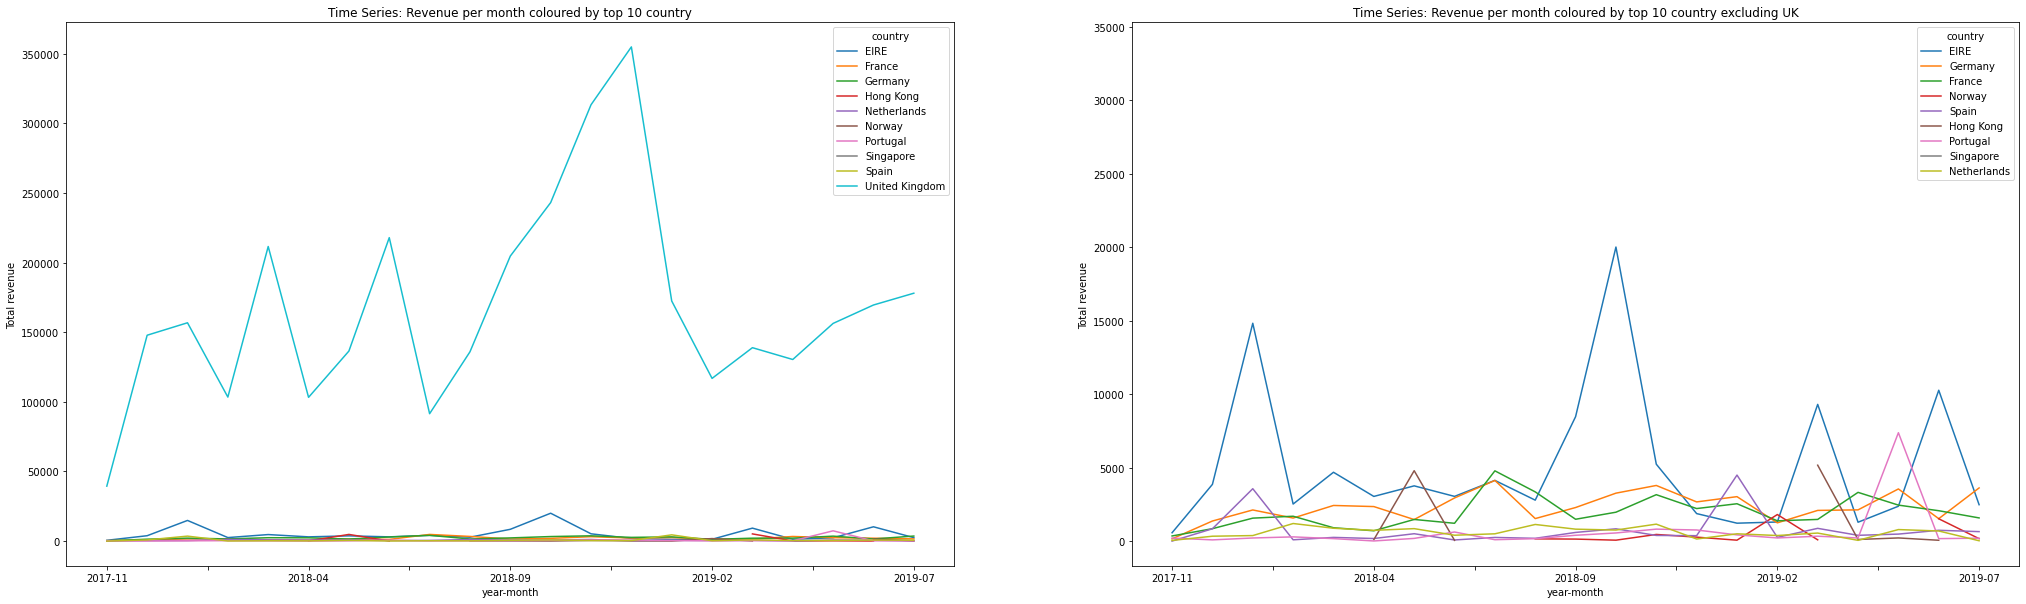

In [20]:
#plot time series of total revenue per month for top 10 countries for all data
fig, axs = plt.subplots(1,2, figsize=(35,10))

dfidxdprice.plot(ax=axs[0])
axs[0].set_title('Time Series: Revenue per month coloured by top 10 country')
axs[0].yaxis.set_label_text('Total revenue')

#plot time series of total revenue over time without the UK to see other 9 countries
dfidxdprice[top10revenuecountries_no_uk].plot(ax=axs[1])
axs[1].set_title('Time Series: Revenue per month coloured by top 10 country excluding UK')
axs[1].yaxis.set_label_text('Total revenue')

Text(0.5, 0, 'Total revenue')

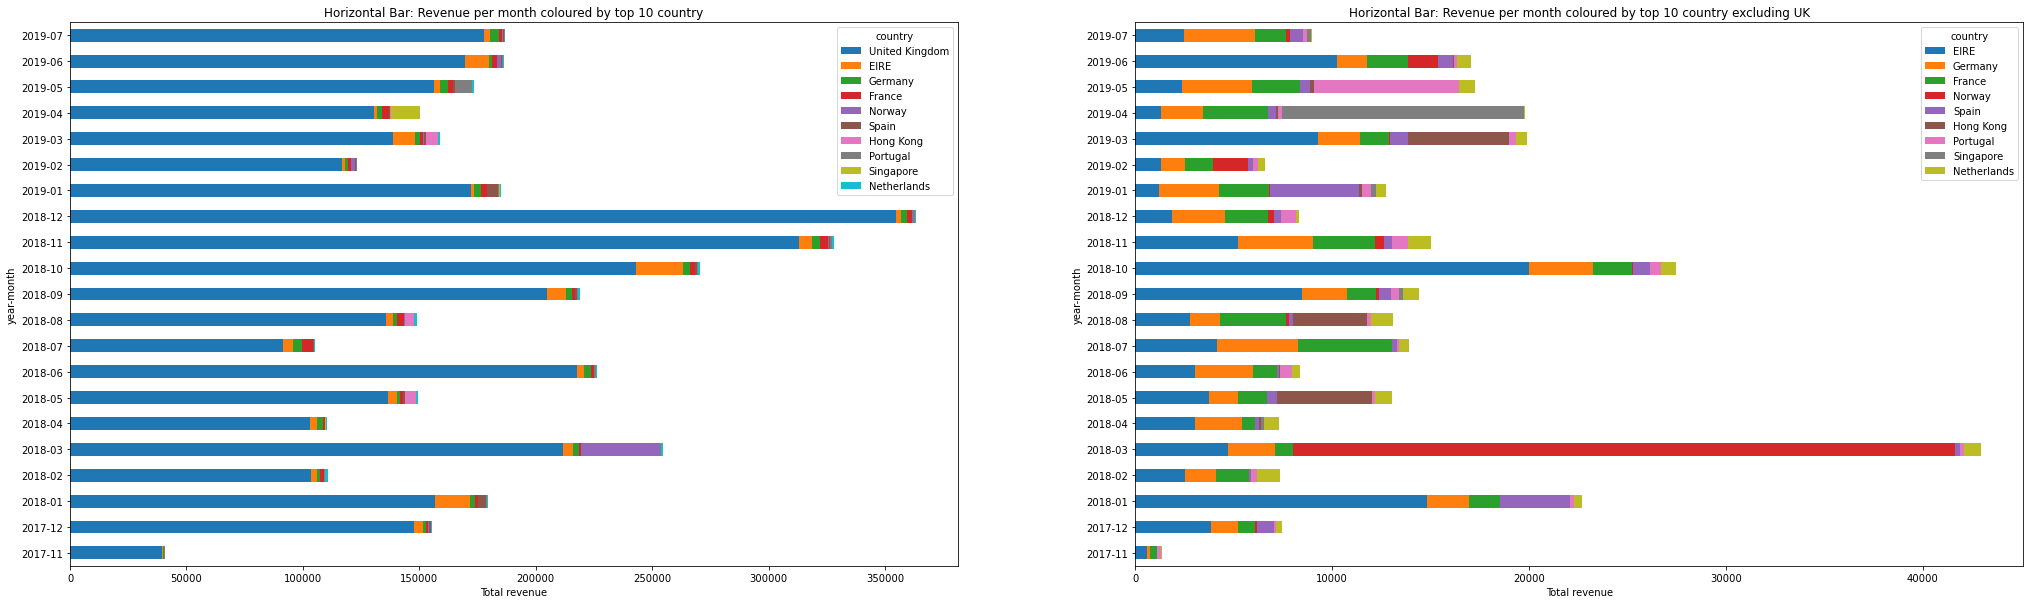

In [21]:
#returning to visualise revenue per month, this time coloured by top 10 country
fig, axs = plt.subplots(1,2, figsize=(35,10))

dfidxdprice[top10revenuecountries].plot(kind='barh', stacked=True, ax=axs[0])
axs[0].set_title('Horizontal Bar: Revenue per month coloured by top 10 country')
axs[0].xaxis.set_label_text('Total revenue')

#visualise revenue per month of top 10 without UK
dfidxdprice[top10revenuecountries_no_uk].plot(kind='barh', stacked=True, ax=axs[1])
axs[1].set_title('Horizontal Bar: Revenue per month coloured by top 10 country excluding UK')
axs[1].xaxis.set_label_text('Total revenue')

#dfidxdprice[top10revenuecountries].plot(kind='barh', stacked=True, figsize=(15,10))

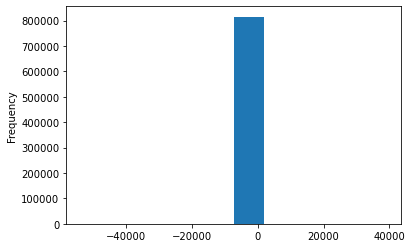

In [45]:
#plot histogram for price
df['price'].plot(kind='hist')
#output shows there are some transactions less than 0 (could these be invoices TO AAVAiL? e.g. AAVAiL costs)

In [71]:
#find the negative transactions
dfnegativeprice = df[df['price'] < 0]
dfnegativeprice
#there are 3 transactions with less than 0 for price

,country,customer_id,invoice,year,month,day,stream_id,times_viewed,price,date,year-month
213562,United Kingdom,NaN,A516228,2018,7,16,B,1,-44031.79,2018-07-16,2018-07
380949,United Kingdom,NaN,A528059,2018,10,17,B,1,-38925.87,2018-10-17,2018-10
598531,United Kingdom,NaN,A506401,2018,4,26,B,1,-53594.36,2018-04-26,2018-04


In [52]:
#subset on price bigger than 0
dfpositiveprice = df[df['price'] > 0]

#sort by price and check top value > 0
dfpositiveprice.sort_values(by='price')[:1]

,country,customer_id,invoice,year,month,day,stream_id,times_viewed,price,date,year-month
421746,United Kingdom,15182.0,522766,2018,9,13,PADS,1,0.001,2018-09-13,2018-09


Text(0.5, 0, 'Price')

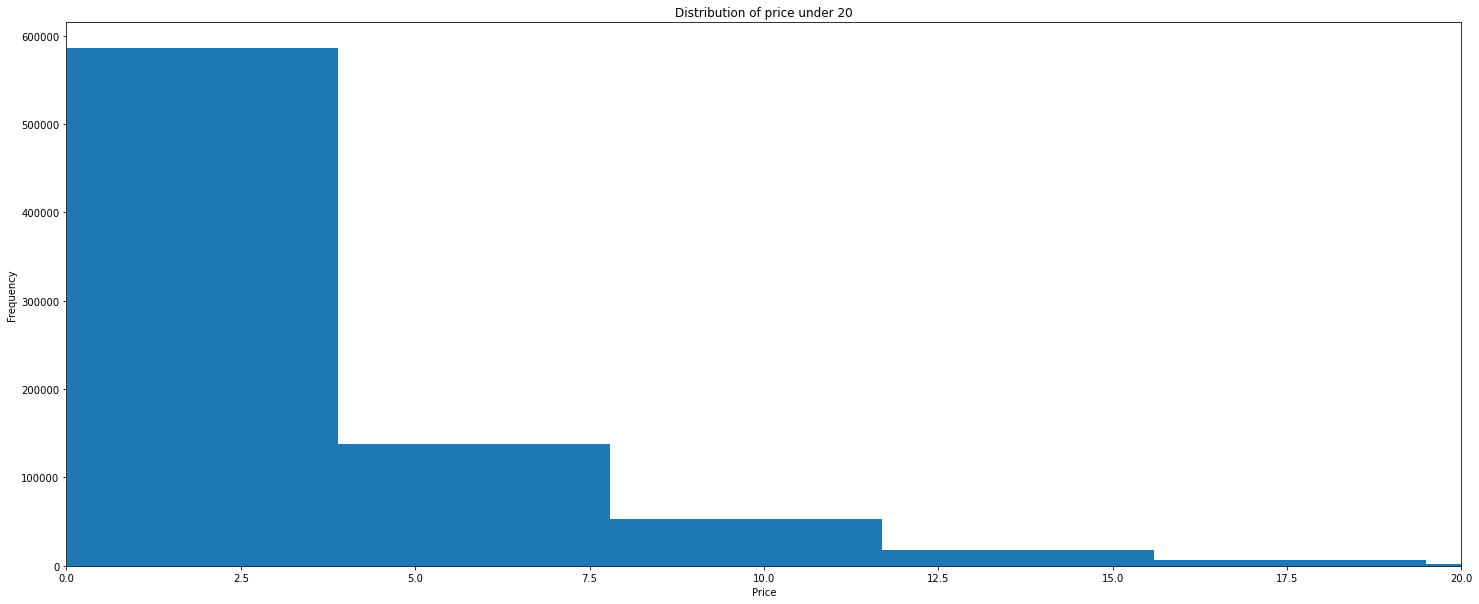

In [97]:
#plot histogram of price for all transactions under 20
dfpositiveprice['price'].plot(kind='hist', bins=10000, figsize=(25,10), xlim=(0,20), title='Distribution of price under 20').set_xlabel('Price')

In [63]:
#confirm total count of transactions with price over 20
df[df['price'] > 20].shape

(7914, 11)

In [64]:
#confirm total count of transactions with price under 20 
df[df['price'] < 20].shape

(807082, 11)

Text(0.5, 0, 'Times Viewed')

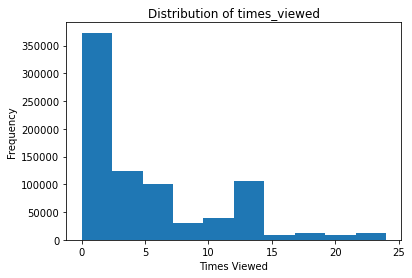

In [115]:
#plot distribution of times viewed
df['times_viewed'].plot(kind='hist', title='Distribution of times_viewed').set_xlabel('Times Viewed')

In [100]:
#how many unique streams?
df['stream_id'].unique()
#5007

[20895, 20866, 85198, 20897, 20898, ..., 17010S, 72226D, 72732, 72759, 84205C]
Length: 5007
Categories (5007, object): [20895, 20866, 85198, 20897, ..., 72226D, 72732, 72759, 84205C]

In [138]:
#show the 50 stream ids with the highest stream count
streamids = df['stream_id'].value_counts()
streamids = pd.DataFrame(streamids)
streamids = streamids.rename(columns={'stream_id' : 'stream transaction count'})
streamids[:50]

,stream transaction count
85123A,5017
22423,3661
85099B,3313
21212,2801
20725,2610
21232,2414
84879,2305
47566,2259
22383,1989
21931,1985


In [102]:
#how many unique customers?
df['customer_id'].unique()
#5226

[15581.0, 13004.0, 17807.0, 16296.0, NaN, ..., 17701.0, 16162.0, 14886.0, 13841.0, 14023.0]
Length: 5226
Categories (5225, float64): [15581.0, 13004.0, 17807.0, 16296.0, ..., 16162.0, 14886.0, 13841.0, 14023.0]

In [139]:
#show the top 50 customers with the highest transactions
customerids = df['customer_id'].value_counts()
customerids = pd.DataFrame(customerids)
customerids = customerids.rename(columns={'customer_id' : 'customer transaction count'})
customerids[:50]

,customer transaction count
17841.0,8809
14911.0,8182
14606.0,5763
12748.0,4560
15311.0,3837
14156.0,3517
14646.0,2853
13089.0,2851
17850.0,2827
15039.0,2506


In [107]:
#how many unique countries?
df['country'].unique()
#43

[United Kingdom, Germany, EIRE, France, Sweden, ..., Brazil, West Indies, Saudi Arabia, Czech Republic, Bermuda]
Length: 43
Categories (43, object): [United Kingdom, Germany, EIRE, France, ..., West Indies, Saudi Arabia, Czech Republic, Bermuda]

In [151]:
#find number of transactions per country
countries = df['country'].value_counts()
countries = pd.DataFrame(countries)
countries = countries.rename(columns={'country' : 'country transaction count'})
countries

,country transaction count
United Kingdom,751228
EIRE,13577
Germany,13336
France,9899
Netherlands,4024
Spain,2606
Switzerland,2326
Belgium,2166
Portugal,1815
Australia,1543


In [113]:
#investigate transactions with top 50 highest price
dfpositiveprice.sort_values(by='price',ascending=False)[:50]

#takeaways:
#all come from UK, except some from Norway on 16 March 2018
#stream ids are 'M', 'AMAZONFEE', 'POST' and there is one large transaction 'BANK CHARGES'
#these transactions are dispersed across the population dataset time window 2017-2019

,country,customer_id,invoice,year,month,day,stream_id,times_viewed,price,date,year-month
240079,United Kingdom,15098.0,C556445,2019,6,7,M,1,38970.00,2019-06-07,2019-06
327512,United Kingdom,NaN,512771,2018,6,14,M,1,25111.09,2018-06-14,2018-06
327515,United Kingdom,17399.0,C512770,2018,6,14,M,2,25111.09,2018-06-14,2018-06
668041,United Kingdom,NaN,C520667,2018,8,24,BANK CHARGES,2,18910.69,2018-08-24,2018-08
73788,United Kingdom,NaN,C540117,2019,1,2,AMAZONFEE,0,16888.02,2019-01-02,2019-01
73776,United Kingdom,NaN,C540118,2019,1,2,AMAZONFEE,2,16453.71,2019-01-02,2019-01
532223,United Kingdom,NaN,537632,2018,12,4,AMAZONFEE,1,13541.33,2018-12-04,2018-12
534926,United Kingdom,NaN,537632,2018,12,4,AMAZONFEE,1,13541.33,2018-12-04,2018-12
534908,United Kingdom,NaN,C537630,2018,12,4,AMAZONFEE,3,13541.33,2018-12-04,2018-12
532224,United Kingdom,NaN,C537630,2018,12,4,AMAZONFEE,3,13541.33,2018-12-04,2018-12


In [164]:
df['date'].unique().shape


(495,)